In [1]:
import sys

sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [2]:
from source.datasets.brain_dataset import BrainDataset
from source.loftr.backbone import ResNetFPN_16_4, ResNetFPN_8_2
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.loftr.fine_preprocess import FinePreprocess
from source.loftr.loss import *
from source.visualization.evaluation_visualization import plot_loss_curve
from source.visualization.training_visualization import plot_grad_flow_hist
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import time
import torch
from source.miscellaneous.evaluation import evaluate_model, read_model_evaluation_metrics
from einops.einops import rearrange
from source.miscellaneous.model_saving import save_model

In [3]:
torch.autograd.set_detect_anomaly(False)

In [4]:
crop_size = 640
affine_transformation_range = 0.25
perspective_transformation_range = 0.000125
patch_size = 16
max_translation_shift = 50
fine_height_width = (crop_size//patch_size)*4
coarse_height_width = crop_size//patch_size
images_directory = "../../data/cyto_downscaled_3344_3904/"
use_train_data = True

dataset_train = BrainDataset(
    images_directory=images_directory,
    train=use_train_data,
    affine_transformation_range=affine_transformation_range,
    perspective_transformation_range=perspective_transformation_range,
    crop_size=crop_size,
    patch_size=patch_size,
    max_translation_shift=max_translation_shift,
    fine_height_width=fine_height_width,
    transform=v2.Compose([v2.Normalize(mean=[0.594], std=[0.204])]),
)

In [5]:
from source.datasets.brain_dataset import collate_fn

In [6]:
batch_size = 2

dataloader_train = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=False,
    collate_fn=collate_fn,
)

In [7]:
learning_rate = 0.0004
weight_decay = 0.001
use_coarse_context = False
use_l2_with_standard_deviation = False
temperature = (
    0.2  # Dont decrease this value, it will yield in overflows (similarity_matrix)
)

device = "cuda" if torch.cuda.is_available() else "cpu"
# block_dimensions_8_2 = [96, 128, 192]
# block_dimensions_16_4 = [64, 96, 128, 192]
block_dimensions =[64, 96, 128, 192]
fine_feature_size = block_dimensions[1]  # 1 for 16_4, 0 for 8_2
coarse_feature_size = block_dimensions[-1]
backbone = ResNetFPN_16_4(block_dimensions=block_dimensions).to(device=device)

positional_encoding = PositionalEncoding(coarse_feature_size).to(device=device)

coarse_loftr = LocalFeatureTransformer(
    feature_dimension=coarse_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"] * 4,
).to(device=device)

coarse_matcher = CoarseMatching(temperature=temperature, confidence_threshold=0.2).to(
    device=device
)

fine_preprocess = FinePreprocess(
    coarse_feature_size=coarse_feature_size,
    fine_feature_size=fine_feature_size,
    window_size=5,
    use_coarse_context=use_coarse_context,
).to(device=device)
fine_loftr = LocalFeatureTransformer(
    feature_dimension=fine_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"],
).to(device=device)
fine_matching = FineMatching(
    return_standard_deviation=use_l2_with_standard_deviation,
).to(device=device)

params = list(backbone.parameters()) + list(coarse_loftr.parameters()) + list(fine_loftr.parameters())
optimizer = torch.optim.Adam(params, weight_decay=weight_decay, lr=learning_rate)

coarse_loss_history = []
fine_loss_history = []
loss_hist_test = []

In [8]:
coarse_loss = "official_focal"
alpha = 0.75
gamma = 2
fine_loss = "l2_std" if use_l2_with_standard_deviation else "l2"

In [9]:
seen_datapoints = 0

In [12]:
print_frequency = 10
epochs = 40
num_accumulation_steps = 4
coarse_batch_loss = 0
fine_batch_loss = 0

for epoch in range(epochs):
    epoch_start_time = time.time()
    for step, batch in enumerate(dataloader_train):
        image_1_crop, image_2_crop, match_matrix, relative_coordinates, _ = batch
        seen_datapoints += image_1_crop.shape[0]
        image_1_crop = image_1_crop.to(device=device)
        image_2_crop = image_2_crop.to(device=device)
        match_matrix = match_matrix.to(device=device)
        relative_coordinates = relative_coordinates.to(device=device)

        coarse_image_feature_1, fine_image_feature_1 = backbone(image_1_crop)
        coarse_image_feature_2, fine_image_feature_2 = backbone(image_2_crop)
        
        coarse_image_feature_1 = positional_encoding(coarse_image_feature_1)
        coarse_image_feature_2 = positional_encoding(coarse_image_feature_2)

        coarse_image_feature_1 = rearrange(
            coarse_image_feature_1, "n c h w -> n (h w) c"
        )
        coarse_image_feature_2 = rearrange(
            coarse_image_feature_2, "n c h w -> n (h w) c"
        )

        coarse_image_feature_1, coarse_image_feature_2 = coarse_loftr(
            coarse_image_feature_1, coarse_image_feature_2
        )

        coarse_matches = coarse_matcher(coarse_image_feature_1, coarse_image_feature_2)

        coarse_matches_ground_truth = {
            "batch_indices": match_matrix.nonzero()[:, 0],
            "row_indices": match_matrix.nonzero()[:, 1],
            "column_indices": match_matrix.nonzero()[:, 2],
        }

        fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_preprocess(
            coarse_image_feature_1=coarse_image_feature_1,
            coarse_image_feature_2=coarse_image_feature_2,
            fine_image_feature_1=fine_image_feature_1,
            fine_image_feature_2=fine_image_feature_2,
            coarse_matches=coarse_matches_ground_truth,
            fine_height_width=fine_height_width,
            coarse_height_width=coarse_height_width,
        )

        fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_loftr(
            fine_image_feature_1_unfold, fine_image_feature_2_unfold
        )

        predicted_relative_coordinates = fine_matching(
            fine_image_feature_1_unfold, fine_image_feature_2_unfold
        )

        if coarse_loss == "focal":
            coarse_loss_value = coarse_focal_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix,
                alpha=alpha,
                gamma=gamma,
            )

        elif coarse_loss == "official_focal":
            coarse_loss_value = coarse_official_focal_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix,
                alpha=alpha,
                gamma=gamma,
            )

        elif coarse_loss == "cross_entropy":
            coarse_loss_value = coarse_cross_entropy_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix,
            )

        if fine_loss == "l2":
            fine_loss_value = fine_l2_loss(
                coordinates_predicted=predicted_relative_coordinates,
                coordinates_ground_truth=relative_coordinates,
            )

        elif fine_loss == "l2_std":
            fine_loss_value = fine_l2_loss_with_standard_deviation(
                coordinates_predicted=predicted_relative_coordinates,
                coordinates_ground_truth=relative_coordinates,
            )

        loss = coarse_loss_value + fine_loss_value
        loss = loss / num_accumulation_steps
        loss.backward()
        coarse_batch_loss += coarse_loss_value.cpu().item()
        fine_batch_loss += fine_loss_value.cpu().item()

        if (step + 1) % num_accumulation_steps == 0 or step == len(dataloader_train) - 1:
            optimizer.step()
            epoch_duration = time.time() - epoch_start_time

            coarse_batch_loss = coarse_batch_loss / num_accumulation_steps
            fine_batch_loss = fine_batch_loss / num_accumulation_steps
            print(
                f"Epoch: {epoch}, Seen Datapoints: {seen_datapoints}, Duration: {epoch_duration:.2f} sec, Coarse Loss: {coarse_batch_loss:.4f}, Fine Loss: {fine_batch_loss:.4f}"
            )
            # plot_grad_flow_hist(backbone.named_parameters())
            optimizer.zero_grad()

            coarse_loss_history.append(coarse_loss_value.cpu().item())
            fine_loss_history.append(fine_loss_value.cpu().item())
            coarse_batch_loss = 0
            fine_batch_loss = 0

    if epoch % 10 == 0:
        hyperparameters = {
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "coarse_context": use_coarse_context,
        "img_size": "3344_3904",
        "ResNet": backbone.__class__.__name__,
        "affine_transformation_range": affine_transformation_range,
        "perspective_transformation_range": perspective_transformation_range,
        "temperature": temperature,
        "batch_size": batch_size,
        "coarse_loss": coarse_loss,
        "fine_loss": fine_loss,
        "use_train_data": use_train_data,
        "block_dimensions": block_dimensions,
        "use_l2_with_standard_deviation": use_l2_with_standard_deviation,
        "seen_datapoints": seen_datapoints,
        "crop_size": crop_size,
        "patch_size": patch_size
        }

        if coarse_loss == "focal":
            hyperparameters["gamma"] = gamma
            hyperparameters["alpha"] = alpha


        models = {"backbone": backbone, "coarse_loftr": coarse_loftr, "fine_loftr": fine_loftr}
        model_directory = save_model(
            models,
            hyperparameters=hyperparameters,
            coarse_loss_history=coarse_loss_history,
            fine_loss_history=fine_loss_history,
        )

        evaluation_metrics = evaluate_model(str(model_directory.split("/")[-1]), confidence_threshold=0.8)
        print(evaluation_metrics["auc"])

Epoch: 0, Seen Datapoints: 96, Duration: 16.53 sec, Coarse Loss: 7.7285, Fine Loss: 0.6890
1.9078205496631566
Epoch: 1, Seen Datapoints: 104, Duration: 16.64 sec, Coarse Loss: 6.9323, Fine Loss: 0.6765
Epoch: 2, Seen Datapoints: 112, Duration: 16.29 sec, Coarse Loss: 6.6762, Fine Loss: 0.6656
Epoch: 3, Seen Datapoints: 120, Duration: 15.69 sec, Coarse Loss: 6.3106, Fine Loss: 0.6498
Epoch: 4, Seen Datapoints: 128, Duration: 15.89 sec, Coarse Loss: 6.7260, Fine Loss: 0.6525
Epoch: 5, Seen Datapoints: 136, Duration: 15.50 sec, Coarse Loss: 5.6346, Fine Loss: 0.6059
Epoch: 6, Seen Datapoints: 144, Duration: 15.45 sec, Coarse Loss: 5.8217, Fine Loss: 0.6229
Epoch: 7, Seen Datapoints: 152, Duration: 15.61 sec, Coarse Loss: 6.5310, Fine Loss: 0.6288
Epoch: 8, Seen Datapoints: 160, Duration: 15.51 sec, Coarse Loss: 5.9262, Fine Loss: 0.6328
Epoch: 9, Seen Datapoints: 168, Duration: 15.51 sec, Coarse Loss: 5.8667, Fine Loss: 0.6007
Epoch: 10, Seen Datapoints: 176, Duration: 15.68 sec, Coarse L

In [13]:
seen_datapoints

408

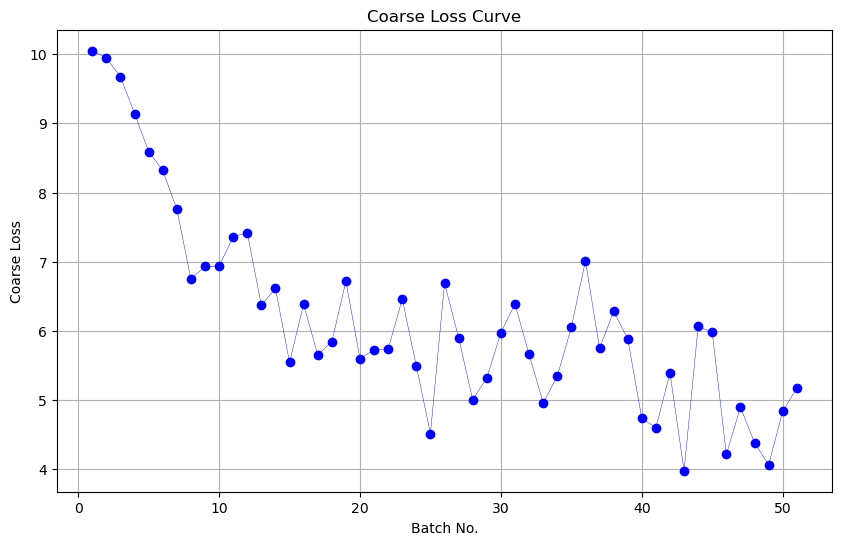

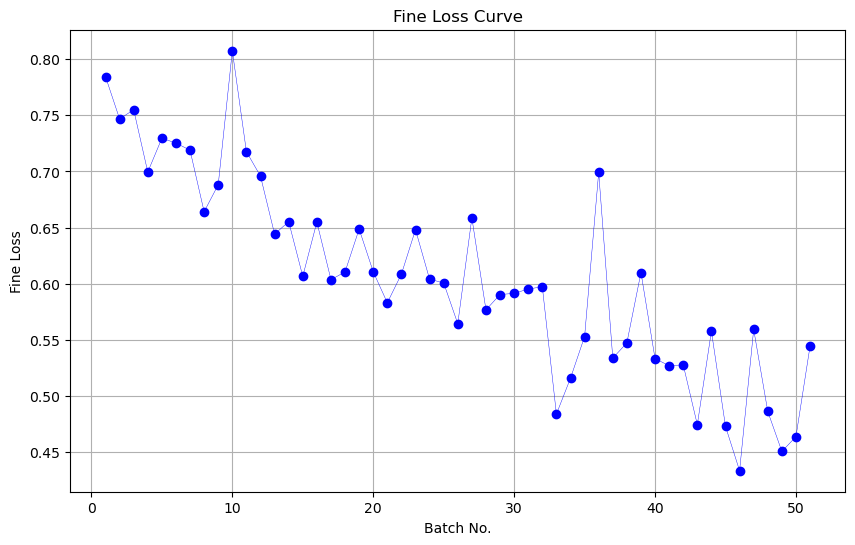

In [14]:
plot_loss_curve(coarse_loss_history, title="Coarse Loss Curve", ylabel="Coarse Loss")
plot_loss_curve(fine_loss_history, title="Fine Loss Curve", ylabel="Fine Loss")